# Covariance matrix for X

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy.random
import scipy
from scipy import integrate
from numpy import sin, cos, pi
#import pycbc.psd

In [2]:
def covX(dur, tau, dt, fs, N, fmin, fmax, tag1, tag2):

    ### Getting total noise PSD S_N
    ## Shot noise PSD
    
    freq = np.logspace(-5, 0, 1000)
    w    = 2*np.pi*freq
    
    n1_psd  = n2p_psd = (6e-12)**2
    S_n_shot_x = 2.*(2*n1_psd*(1-cos(2*w*tau)) + (2*n2p_psd)*(1-cos(3*w*tau)))

    # TM-motion PSD
    delta1_psd = delta2p_psd = (2.4e-15)**2
    S_n_delta_x  = 2*(2*delta1_psd*(1-cos(4*w*tau)) + 8*delta2p_psd*(1-cos(2*w*tau)))
    S_n_delta_x *= (1 + ((0.4e-3)/freq)**2)*(1 + (freq/(8e-3))**4)/(w**4) # Shaping the noise


    ## DWS noise PSD
    # Pitch
    c1_eta = c1p_eta = c1_FS_eta = c1p_FS_eta = c2_eta = c2p_eta = c2_FS_eta = c2p_FS_eta = c3_eta = c3p_eta = c3_FS_eta = c3p_FS_eta = 5e-3 # Upper bound on coeffs
    n_eta1_psd = n_eta1p_psd = n_eta2p_psd = n_eta3_psd = ((35e-9)/300.)**2
    
    S_n_eta_x  = n_eta1_psd*(c1_eta**2 + c2p_FS_eta**2 + 2*c1_eta*c2p_FS_eta*cos(2*w*tau))
    S_n_eta_x += n_eta1p_psd*(c1p_eta**2 + c3_FS_eta**2 + 2*c1p_eta*c3_FS_eta*cos(2*w*tau))
    S_n_eta_x += n_eta2p_psd*(c2p_eta**2 + c1_FS_eta**2 + 2*c2p_eta*c1_FS_eta)
    S_n_eta_x += n_eta3_psd*(c3_eta**2 + c1p_FS_eta**2 + 2*c3_eta*c1p_FS_eta)
    S_n_eta_x *= (2-2*cos(2*w*tau)) # TDI-X transfer fn
    #S_n_eta_x *= 0
    
    # Yaw - signal as noise
    if tag2 == 'LPF':
        w0_y = 2*np.pi*(3.75e-3)
        w1_y = 2*np.pi*(4.5e-3)
        w2_y = 2*np.pi*(1e-1)                   
        phi1_psd = phi1p_psd = phi2p_psd = phi3_psd = ((4e-9)*(w**2 + w0_y**2)/((w**2 + w1_y**2)*(w**2 + w2_y**2)))**2
        
    else:
        phi1_psd  = phi1p_psd = phi2p_psd = phi3_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
        
    c1 = c1p = c1_FS = c1p_FS = c2 = c2p = c2_FS = c2p_FS = c3 = c3p = c3_FS = c3p_FS = 5e-3 # Upper bound on coeffs
    
    S_n_phi_x  = phi1_psd*(c1**2 + c2p_FS**2 + 2*c1*c2p_FS*cos(2*w*tau))
    S_n_phi_x += phi1p_psd*(c1p**2 + c3_FS**2 + 2*c1p*c3_FS*cos(2*w*tau))
    S_n_phi_x += phi2p_psd*(c2p**2 + c1_FS**2 + 2*c2p*c1_FS)
    S_n_phi_x += phi3_psd*(c3**2 + c1p_FS**2 + 2*c3*c1p_FS)
    S_n_phi_x *= (2-2*cos(2*w*tau)) # TDI-X transfer fn
    #S_n_phi_x *= 0
    
    ## GW noise PSD
    m1, m2, f1, f2 = -0.34020763866501563, -7.956580873845239, 2.000050001250031e-05, 0.019400485012125303
    ampsq = (0.3e-23)**2

    S_gw_estimate  = ampsq
    S_gw_estimate *= (freq**2 + f1**2)**(m1)
    S_gw_estimate *= (freq**2 + f2**2)**(m2-m1)

    # Total noise S_N = shot noise + TM-motion noise + DWS noise + GW noise
    S_N = S_n_shot_x + S_n_delta_x +S_gw_estimate + S_n_eta_x + S_n_phi_x
    
    
    ## Integrands
    H_modsq = 2 - 2*cos(2*w*tau)
    
    ## DWS signals
    if tag2=='LPF':
        w0 = 2*np.pi*(1e-3)
        w1 = 2*np.pi*(1e-2)
        w2 = 2*np.pi*(1e-1)
        eta1_psd = eta1p_psd = eta2p_psd = eta3_psd = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
        theta1_psd = theta1p_psd = theta2p_psd = theta3_psd = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
        
    else:
        eta1_psd = eta1p_psd = eta2p_psd = eta3_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
        theta1_psd = theta1p_psd = theta2p_psd = theta3_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
    
    theta_o = 0#30.*pi/180 # Half of opening angle b/w MOSAs

    # |H|^2 |phi|^2 ~ |H|^2 phi_psd*T
    d11 = integrate_fn(H_modsq*(eta1_psd*cos(theta_o)**2 + theta1_psd*sin(theta_o)**2)*dur, S_N, w, fmin, fmax)
    d12 = integrate_fn(H_modsq*(eta1_psd*cos(theta_o)**2 + theta1_psd*sin(theta_o)**2)*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    d33 = integrate_fn(H_modsq*(eta1p_psd*cos(theta_o)**2 + theta1p_psd*sin(theta_o)**2)*dur, S_N, w, fmin, fmax)
    d34 = integrate_fn(H_modsq*(eta1p_psd*cos(theta_o)**2 + theta1p_psd*sin(theta_o)**2)*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    d55 = integrate_fn(H_modsq*(eta2p_psd*cos(theta_o)**2 + theta2p_psd*sin(theta_o)**2)*dur, S_N, w, fmin, fmax)
    d66 = integrate_fn(H_modsq*(eta3_psd*cos(theta_o)**2 + theta3_psd*sin(theta_o)**2)*dur, S_N, w, fmin, fmax)

    d_vec = d11, d12, d33, d34, d55, d66

    cov_x = np.asarray(make_covX_matrix(d_vec, dur))

    if tag1 == 'plot':  
        return cov_x, H_modsq, phi1_psd*dur, S_N, freq
    else: 
        return cov_x
    
def make_covX_matrix(d_vec, dur):
    
    d11, d12, d33, d34, d55, d66 = d_vec
    
    matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0, 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0, 0, 0],[0, 0, d33/(d33**2 - d34**2), d34/(-d33**2 + d34**2), 0, 0], [0, 0, d34/(-d33**2 + d34*2), d33/(d33**2 - d34**2), 0, 0], [0, 0, 0, 0, 1./d55, 0], [0, 0, 0, 0, 0, 1./d66]]
    return matrix


def integrate_fn(numerator, S_N, w, wmin, wmax):

    integrand = numerator/S_N
    
    # Set limits and resize arrays before integral
    w_max_idx = find_nearest(w, wmax)
    w = w[:w_max_idx+1] # +1 to include the index with value closest to wmax
    
    w_min_idx = find_nearest(w, wmin)
    w = w[w_min_idx:]
    
    integrand = integrand[w_min_idx:w_max_idx+1]
    result    = integrate.simps(integrand, x=w, axis=-1, even='avg')

    return result

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def return_diag_covx(covx):
    
    return covx[0][0]**0.5, covx[1][1]**0.5, covx[2][2]**0.5, covx[3][3]**0.5, covx[4][4]**0.5, covx[5][5]**0.5
    

In [5]:
fs  = 8.
dt  = 1./fs
tau = 2.5e9/3e8
#dur = 1*24*3600 # 1 day
dur = 10*60 # 10 mins
t   = np.arange(0, dur, dt)
N   = len(t)
wmin = 2*np.pi*1./dur
#wmax = 2*np.pi*4e-2
wmax = 2*np.pi

DWS = 'LPF'

print('T = ', dur)
print('Integration limits: ', wmin, wmax)

T =  600
Integration limits:  0.010471975511965976 6.283185307179586


In [6]:
covX_matrix, H_modsq, phi1_modsq, S_N, freq =  covX(dur, tau, dt, fs, N, wmin, wmax, 'plot', DWS)

print('\n')
print('\n'.join([' '.join(['{:4}'.format(item) for item in row]) 
      for row in covX_matrix]))



2.2896797339632502e-07 5.762585590475012e-08  0.0  0.0  0.0  0.0
5.762585590475012e-08 2.2896797339632502e-07  0.0  0.0  0.0  0.0
 0.0  0.0 2.2896797339632502e-07 5.762585590475012e-08  0.0  0.0
 0.0  0.0 5.397576752923586e-08 2.2896797339632502e-07  0.0  0.0
 0.0  0.0  0.0  0.0 2.1446490023942068e-07  0.0
 0.0  0.0  0.0  0.0  0.0 2.1446490023942068e-07


In [7]:
# Trace of CovX for current integration bounds seen above

for i in range(6):
    print(0.25*covX_matrix[i][i]**0.5)
    
#print(covX_matrix[0][0]/covX_matrix[5][5])

0.00011962649513076237
0.00011962649513076237
0.00011962649513076237
0.00011962649513076237
0.0001157758880983592
0.0001157758880983592


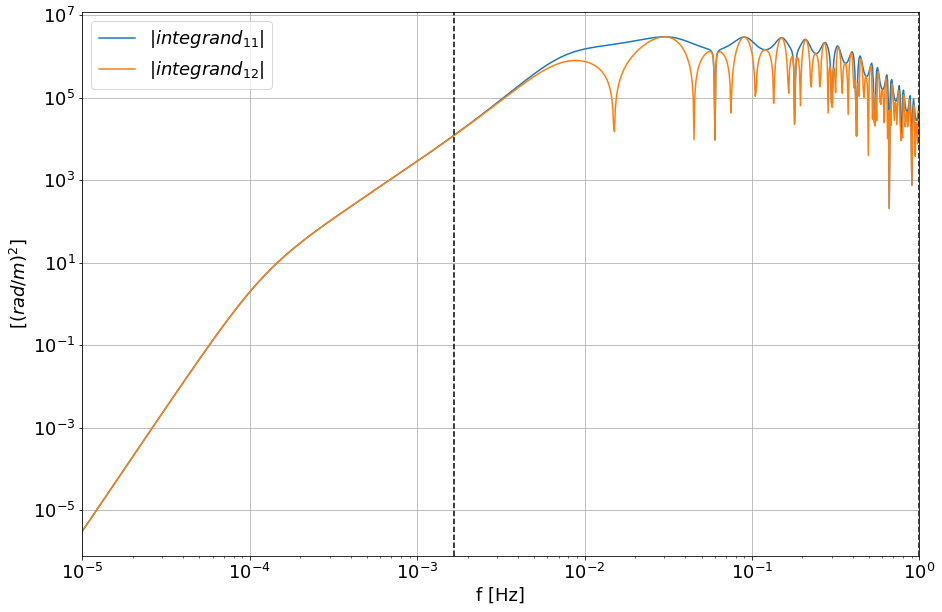

In [8]:
# Checking frequency dependence of integrands

fig = plt.figure(figsize=(15, 10))
plt.loglog(freq, np.abs(H_modsq*phi1_modsq)/S_N, label='$|integrand_{11}|$')
plt.loglog(freq, np.abs(H_modsq*phi1_modsq*cos(2*2*np.pi*freq*tau)/S_N), label='$|integrand_{12}|$')
#plt.semilogx(freq, H_modsq*phi1_modsq*cos(2*2*np.pi*freq*tau)/S_N, label='integrand_12')
plt.xlabel('f [Hz]')
plt.ylabel('[$(rad/m)^2$]')
plt.xlim([1e-5, 1])
#plt.ylim([1e1, 1e12])

# Integration bounds
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid()#True, which="both", ls="--")
plt.savefig('Figures/FIM_integrands_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

<ipython-input-2-16e956121f77>:99: RuntimeWarning: invalid value encountered in double_scalars
  matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0, 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0, 0, 0],[0, 0, d33/(d33**2 - d34**2), d34/(-d33**2 + d34**2), 0, 0], [0, 0, d34/(-d33**2 + d34*2), d33/(d33**2 - d34**2), 0, 0], [0, 0, 0, 0, 1./d55, 0], [0, 0, 0, 0, 0, 1./d66]]
<ipython-input-2-16e956121f77>:99: RuntimeWarning: divide by zero encountered in double_scalars
  matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0, 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0, 0, 0],[0, 0, d33/(d33**2 - d34**2), d34/(-d33**2 + d34**2), 0, 0], [0, 0, d34/(-d33**2 + d34*2), d33/(d33**2 - d34**2), 0, 0], [0, 0, 0, 0, 1./d55, 0], [0, 0, 0, 0, 0, 1./d66]]


f_min =  0.0016666666666666666


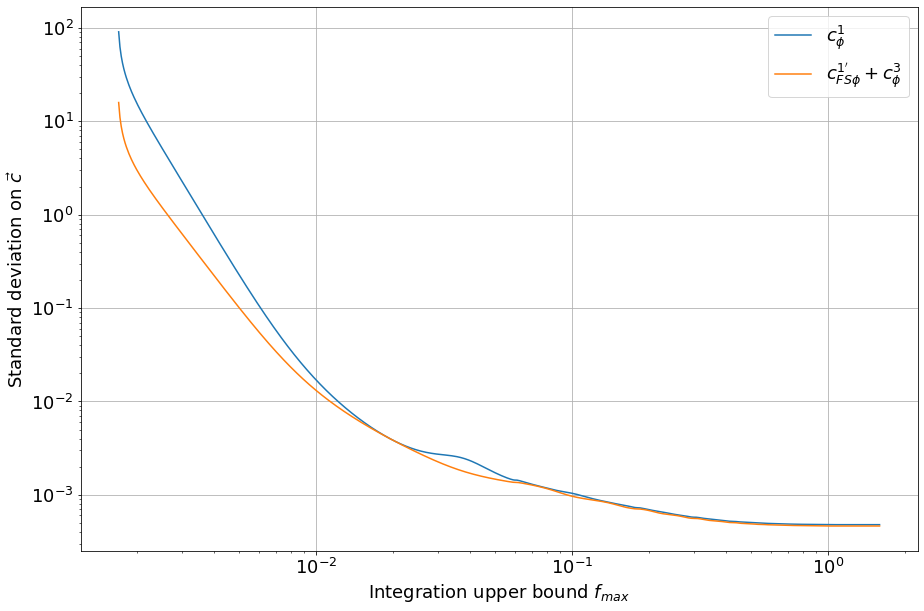

In [9]:
## Changing max bound to see if we can minimize the standard deviation on TTL coefficient c1 (keeping min bound constant)

lower_bound = int(np.log(wmin))
wmax_vec = np.logspace(lower_bound, 1, 1000)
sigma_c1_vec_max = []
sigma_c6_vec_max = []

for i in range(len(wmax_vec)):
    covX_matrix = covX(dur, tau, dt, fs, N, wmin, wmax_vec[i], 'no plot', DWS)
    sigma_c1_vec_max.append(covX_matrix[0][0]**0.5)
    sigma_c6_vec_max.append(covX_matrix[5][5]**0.5)
    
fig = plt.figure(figsize=(15, 10))
plt.loglog(wmax_vec/(2*np.pi), sigma_c1_vec_max, label='$c_{\\phi}^1$')
plt.loglog(wmax_vec/(2*np.pi), sigma_c6_vec_max, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
plt.ylabel('Standard deviation on $\\vec{c}$')
plt.xlabel('Integration upper bound $f_{max}$')
#plt.axvline(x=wmin/(2*np.pi), ls='--', c='k', label='Current $f_{min}$')
plt.legend()
plt.grid()#True, which="both", ls="--")
plt.savefig('Figures/sigma_vary-fmax_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

print('f_min = ', wmin/(2*np.pi))

<ipython-input-2-16e956121f77>:99: RuntimeWarning: invalid value encountered in double_scalars
  matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0, 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0, 0, 0],[0, 0, d33/(d33**2 - d34**2), d34/(-d33**2 + d34**2), 0, 0], [0, 0, d34/(-d33**2 + d34*2), d33/(d33**2 - d34**2), 0, 0], [0, 0, 0, 0, 1./d55, 0], [0, 0, 0, 0, 0, 1./d66]]
<ipython-input-2-16e956121f77>:99: RuntimeWarning: divide by zero encountered in double_scalars
  matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0, 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0, 0, 0],[0, 0, d33/(d33**2 - d34**2), d34/(-d33**2 + d34**2), 0, 0], [0, 0, d34/(-d33**2 + d34*2), d33/(d33**2 - d34**2), 0, 0], [0, 0, 0, 0, 1./d55, 0], [0, 0, 0, 0, 0, 1./d66]]


f_max =  1.0 0.021503051853111046


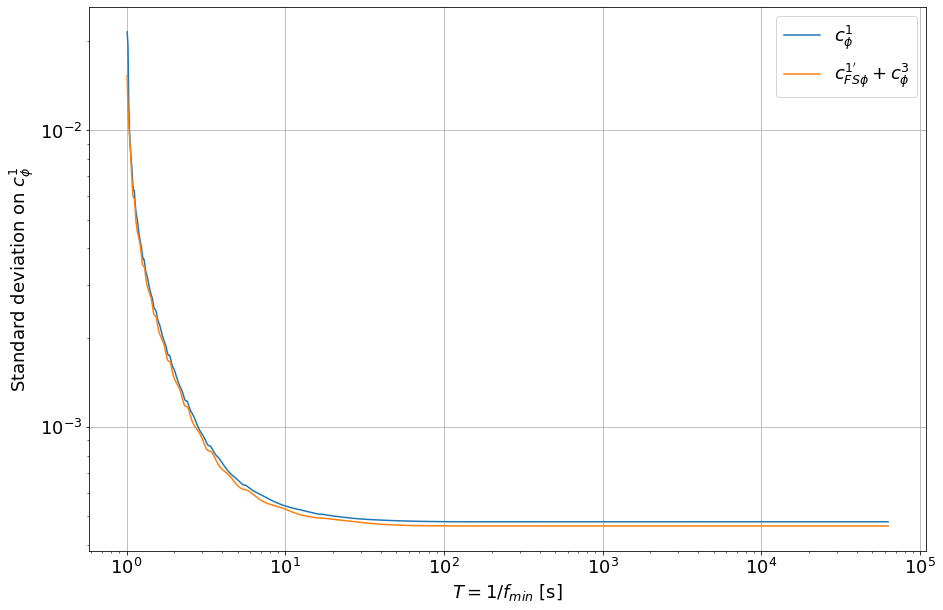

In [10]:
## Changing max bound to see if we can minimize the standard deviation on TTL coefficient c1 (keeping min bound constant)

upper_bound = int(np.log(wmax))
wmin_vec = np.logspace(-4, upper_bound, 1000)
sigma_c1_vec_min = []
sigma_c6_vec_min = []

for i in range(len(wmin_vec)):
    covX_matrix = covX(dur, tau, dt, fs, N, wmin_vec[i], wmax, 'no plot', DWS)
    sigma_c1_vec_min.append(covX_matrix[0][0]**0.5) 
    sigma_c6_vec_min.append(covX_matrix[5][5]**0.5)
    
    
T_plot = 1/(wmin_vec/(2*np.pi))

fig = plt.figure(figsize=(15, 10))
plt.loglog(T_plot, sigma_c1_vec_min, label='$c_{\\phi}^1$')
plt.loglog(T_plot, sigma_c6_vec_min, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
plt.xlabel('$T=1/f_{min}$ [s]')
#plt.loglog(wmin_vec/(2*np.pi), sigma_c1_vec_min, label='$c_{\\phi}^1$')
#plt.loglog(wmin_vec/(2*np.pi), sigma_c6_vec_min, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
#plt.xlabel('Integration lower bound $f_{min}$')

plt.ylabel('Standard deviation on $c_{\\phi}^1$')
#plt.axvline(x=wmax/(2*np.pi), ls='--', c='k', label='Current $f_{max}$')
#plt.ylim([0.99*min(sigma_c1_vec_min), 1.01*max(sigma_c1_vec_min)])
plt.tick_params(axis='y', which='major')
plt.legend()
plt.grid()#True, which="both", ls="--")

plt.savefig('Figures/sigma_vary-T_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)
#plt.savefig('Figures/sigma_vary-fmin_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

print('f_max = ', wmax/(2*np.pi), max(sigma_c1_vec_min))

In [11]:
## Changing both bounds to see if we can minimize the standard deviation on TTL coefficient c1

from matplotlib.colors import LogNorm

N_contour = 200
wmax_vec = np.linspace(0, 2, N_contour)
wmin_vec = np.linspace(0, 2, N_contour)
Wmax, Wmin = np.meshgrid(wmax_vec, wmin_vec)
sigma11 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma22 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma33 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma44 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma55 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma66 = np.zeros((len(wmax_vec), len(wmax_vec)))


for i in range(N_contour):
    for j in range(N_contour):
        if Wmax[i,j] < Wmin[i,j]:
            covX_matrix = covX(dur, tau, dt, fs, N, Wmax[i,j], Wmin[i,j], 'no plot', DWS)
            sigma11[i,j]  = 0.25*covX_matrix[0][0]**0.5
            sigma22[i,j]  = 0.25*covX_matrix[1][1]**0.5
            sigma33[i,j]  = 0.25*covX_matrix[2][2]**0.5
            sigma44[i,j]  = 0.25*covX_matrix[3][3]**0.5
            sigma55[i,j]  = 0.25*covX_matrix[4][4]**0.5
            sigma66[i,j]  = 0.25*covX_matrix[5][5]**0.5
        else:
            sigma11[i,j]  = 0
            sigma22[i,j]  = 0
            sigma33[i,j]  = 0
            sigma44[i,j]  = 0
            sigma55[i,j]  = 0
            sigma66[i,j]  = 0
            

<ipython-input-2-16e956121f77>:99: RuntimeWarning: invalid value encountered in double_scalars
  matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0, 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0, 0, 0],[0, 0, d33/(d33**2 - d34**2), d34/(-d33**2 + d34**2), 0, 0], [0, 0, d34/(-d33**2 + d34*2), d33/(d33**2 - d34**2), 0, 0], [0, 0, 0, 0, 1./d55, 0], [0, 0, 0, 0, 0, 1./d66]]
<ipython-input-2-16e956121f77>:99: RuntimeWarning: divide by zero encountered in double_scalars
  matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0, 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0, 0, 0],[0, 0, d33/(d33**2 - d34**2), d34/(-d33**2 + d34**2), 0, 0], [0, 0, d34/(-d33**2 + d34*2), d33/(d33**2 - d34**2), 0, 0], [0, 0, 0, 0, 1./d55, 0], [0, 0, 0, 0, 0, 1./d66]]


<ipython-input-12-29ad8969f587>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('32%s' %i)
<ipython-input-12-29ad8969f587>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c11 = plt.pcolor(Wmax/(2*np.pi), Wmin/(2*np.pi), sigma11, norm=LogNorm(vmin=.5e-8, vmax=1e-7))


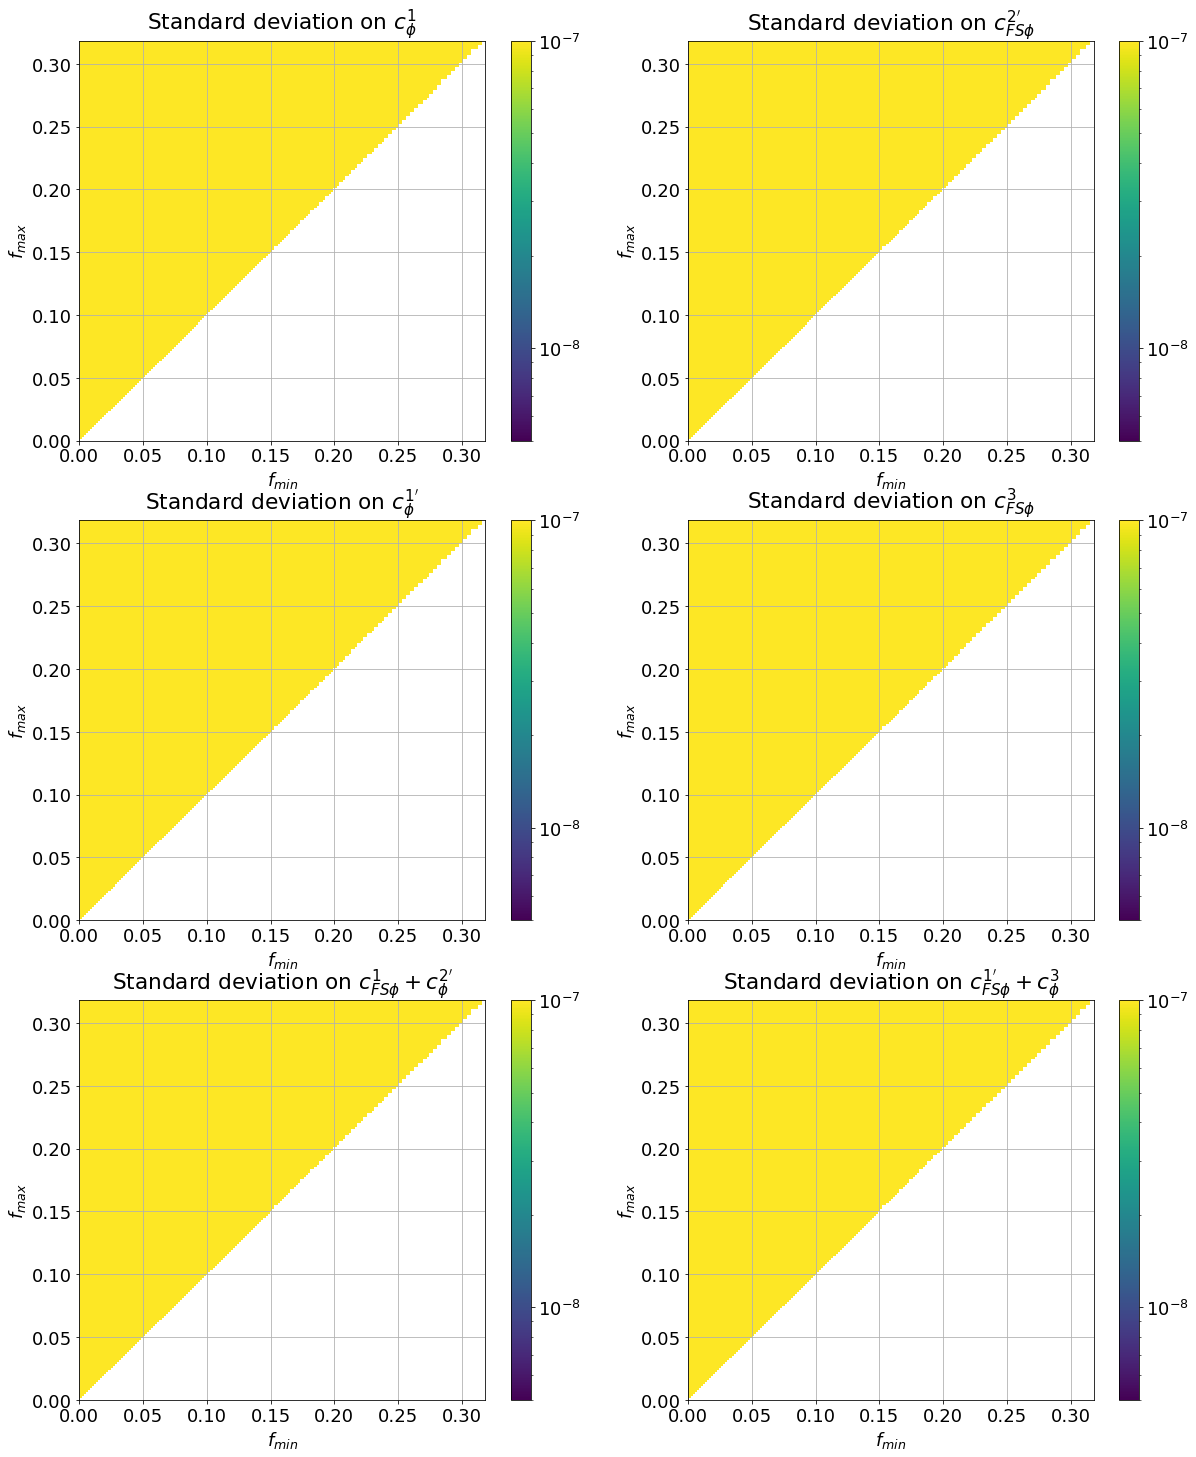

In [12]:
## Plotting contours for sigma

sigmas  = [sigma11, sigma22, sigma33, sigma44, sigma55, sigma66]
ylabels = ['c_{\\phi}^1','c_{FS\\phi}^{2^{\prime}}', 'c_{\\phi}^{1^{\prime}}', 'c_{FS\\phi}^3', 'c_{FS\\phi}^{1} + c_{\\phi}^{2^{\prime}}', 'c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}']

fig= plt.figure(figsize=(20, 25))
for i in range(6):
    i += 1
    plt.subplot('32%s' %i)
    i -= 1
    plt.title('Standard deviation on $%s$' %ylabels[i])
    c11 = plt.pcolor(Wmax/(2*np.pi), Wmin/(2*np.pi), sigma11, norm=LogNorm(vmin=.5e-8, vmax=1e-7))
    #c11 = plt.pcolor(np.log(Wmax/(2*np.pi)), np.log10(Wmin/(2*np.pi)), sigmas[i], norm=LogNorm(vmin=.5e-5, vmax=1e-4))
    #plt.xlabel('log($f_{min}$)')
    #plt.ylabel('log($f_{max}$)')
    plt.xlabel('$f_{min}$')
    plt.ylabel('$f_{max}$')
    plt.colorbar(c11)
    plt.grid()
plt.savefig('Figures/contour_X_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)


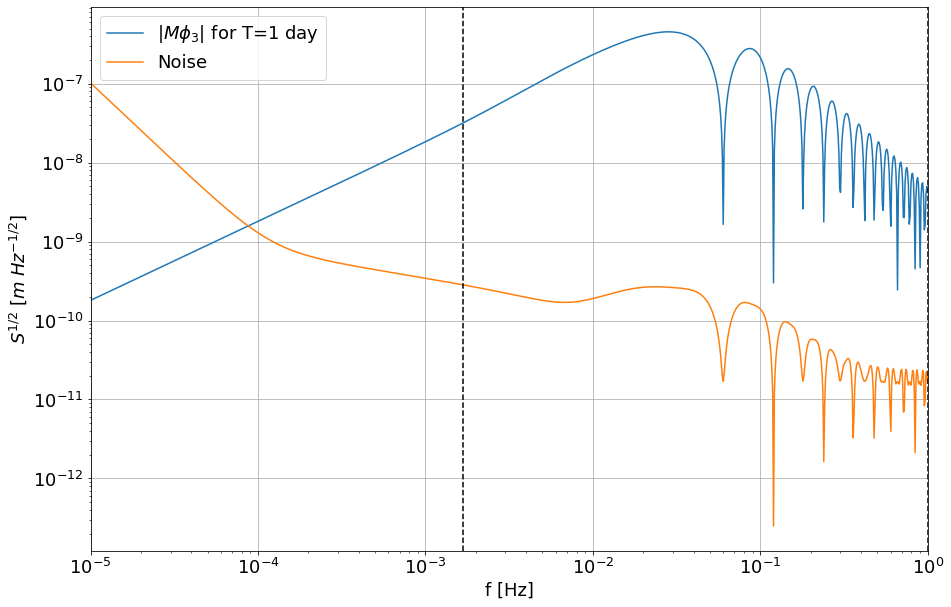

In [15]:
# Plotting integrand components individually

A       = 10e-9
T_jitt  = 24*3600
w0_jitt = 2*pi*15e-3

#phi1_jitter_modsq = (A**2)*(w0 + cos(2*w0*T_jitt))/(8*(T_jitt**2)*(w0-w)*(w0+w))

fig = plt.figure(figsize=(15, 10))
plt.loglog(freq, ((np.abs(phi1_modsq**0.5))*H_modsq**0.5), label='$|M \phi_3|$ for T=1 day')
#plt.loglog(freq, ((np.abs(phi1_jitter_modsq)**0.5)*H_modsq**0.5), label='$|M \phi_3|$ for T=1 day')
plt.loglog(freq, S_N**0.5, label='Noise')
plt.xlabel('f [Hz]')
plt.ylabel('$S^{1/2}$ $[m \; Hz^{-1/2}]$')
plt.xlim([1e-5, 1])
plt.legend()
plt.grid()

# Integration bounds
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.savefig('Figures/FIM_integrand_components_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

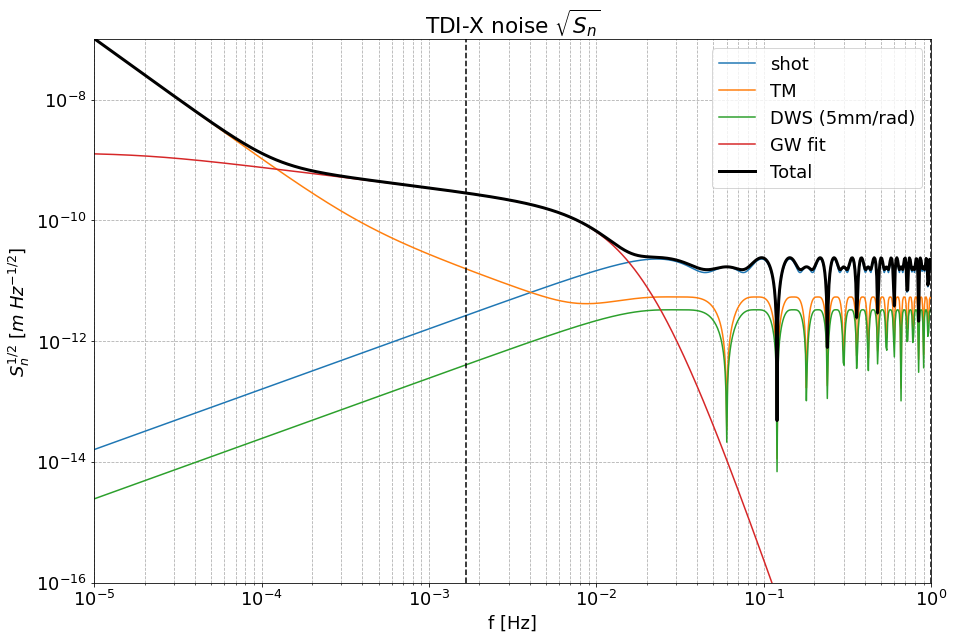

In [16]:
# Plotting various noise curves

freq = np.logspace(-5, 0, 1000)
w    = 2*np.pi*freq

# Shot-noise
n1_psd  = (6e-12)**2
n2p_psd = (6e-12)**2

S_n_shot_x = 2.*(2*n1_psd*(1-cos(2*w*tau)) + (2*n2p_psd)*(1-cos(3*w*tau)))
S_n_shot   = n1_psd*np.ones(1000)

# TM-motion PSD
delta1_psd  = (2.4e-15)**2
delta2p_psd = (2.4e-15)**2
    
S_n_delta_x  = 2*(2*delta1_psd*(1-cos(4*w*tau)) + 8*delta2p_psd*(1-cos(2*w*tau)))
S_n_delta_x *= (1 + ((0.4e-3)/freq)**2)*(1 + (freq/(8e-3))**4)/(w**4) # Shaping the noise

S_delta = delta1_psd
S_delta *= (1 + ((0.4e-3)/freq)**2)*(1 + (freq/(8e-3))**4)/(w**4) # Shaping the noise

# DWS noise PSD
# Yaw
c1 = c1p = c1_FS = c1p_FS = c2 = c2p = c2_FS = c2p_FS = c3 = c3p = c3_FS = c3p_FS = 5e-3 # Upper bound on coeffs
n_phi1_psd = n_phi1p_psd = n_phi2p_psd = n_phi3_psd = ((35e-9)/300.)**2

S_n_phi_x  = n_phi1_psd*(c1**2 + c2p_FS**2 + 2*c1*c2p_FS*cos(2*w*tau))
S_n_phi_x += n_phi1p_psd*(c1p**2 + c3_FS**2 + 2*c1p*c3_FS*cos(2*w*tau))
S_n_phi_x += n_phi2p_psd*(c2p**2 + c1_FS**2 + 2*c2p*c1_FS)
S_n_phi_x += n_phi3_psd*(c3**2 + c1p_FS**2 + 2*c3*c1p_FS)
S_n_phi_x *= (2-2*cos(2*w*tau)) # TDI-X transfer fn

# Pitch
c1_eta = c1p_eta = c1_FS_eta = c1p_FS_eta = c2_eta = c2p_eta = c2_FS_eta = c2p_FS_eta = c3_eta = c3p_eta = c3_FS_eta = c3p_FS_eta = 5e-3 # Upper bound on coeffs
n_eta1_psd = n_eta1p_psd = n_eta2p_psd = n_eta3_psd = ((35e-9)/300.)**2
n_theta1_psd = n_theta1p_psd = n_theta2p_psd = n_theta3_psd = ((35e-9)/300.)**2

S_n_eta_x  = (3*n_eta1_psd + n_theta1_psd)*(c1_eta**2 + c2p_FS_eta**2 + 2*c1_eta*c2p_FS_eta*cos(2*w*tau))
S_n_eta_x += (3*n_eta1p_psd + n_theta1p_psd)*(c1p_eta**2 + c3_FS_eta**2 + 2*c1p_eta*c3_FS_eta*cos(2*w*tau))
S_n_eta_x += n_phi2p_psd*(c2p_eta**2 + c1_FS_eta**2 + 2*c2p_eta*c1_FS_eta)
S_n_eta_x += n_phi3_psd*(c3_eta**2 + c1p_FS_eta**2 + 2*c3_eta*c1p_FS_eta)
S_n_eta_x *= (2-2*cos(2*w*tau)) # TDI-X transfer fn

# GW noise PSD
m1, m2, f1, f2 = -0.34020763866501563, -7.956580873845239, 2.000050001250031e-05, 0.019400485012125303
ampsq = (0.3e-23)**2

S_gw_estimate  = ampsq
S_gw_estimate *= (freq**2 + f1**2)**(m1)
S_gw_estimate *= (freq**2 + f2**2)**(m2-m1)

# Total
S_n = S_n_shot_x + S_n_delta_x + S_gw_estimate + S_n_phi_x + S_n_eta_x

fig = plt.figure(figsize=(15, 10))
plt.title('TDI-X noise $\\sqrt{S_n}$')
plt.loglog(freq, S_n_shot_x**0.5, label='shot')
plt.loglog(freq, S_n_delta_x**0.5, label='TM')
plt.loglog(freq, S_n_phi_x**0.5, label='DWS (5mm/rad)')
plt.loglog(freq, S_gw_estimate**0.5, label='GW fit')
plt.loglog(freq, S_n**0.5, label='Total', c='k', linewidth=3.0)
plt.ylabel('$S_n^{1/2}$ $[m \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
plt.ylim([1e-16, 1e-7])
#plt.axvline(x=3e-3, ls='--', c='k')
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('Figures/FIM_noise_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

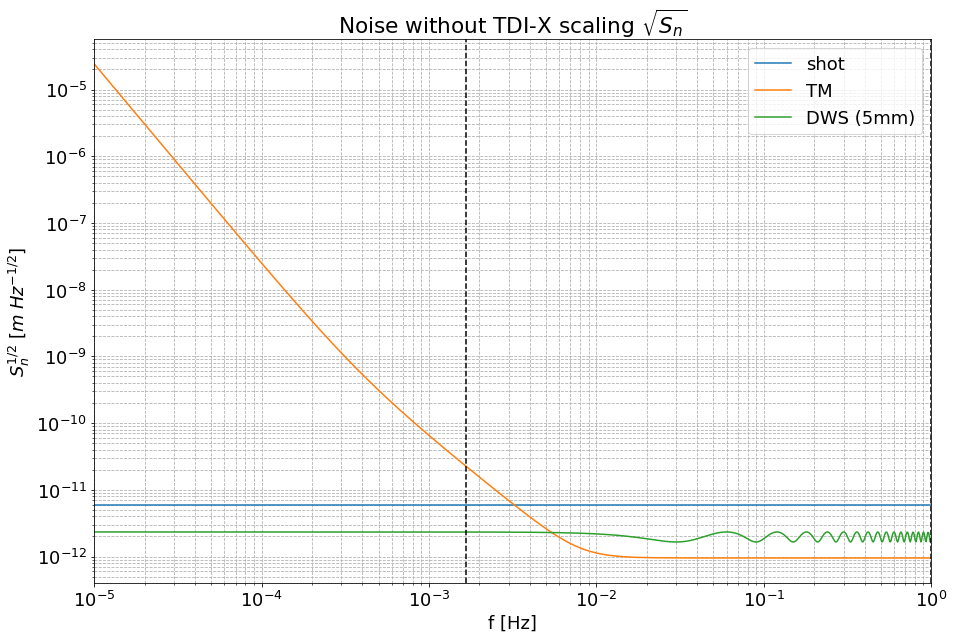

In [17]:
# Without TDI-X transfer function

H = (2-2*cos(2*w*tau)) # Hmodsq

S_n_withoutX = S_n_shot + S_delta + S_n_phi_x/H + S_gw_estimate/H

fig = plt.figure(figsize=(15, 10))
plt.title('Noise without TDI-X scaling $\\sqrt{S_n}$')
plt.loglog(freq, S_n_shot**0.5, label='shot')
plt.loglog(freq, S_delta**0.5, label='TM')
plt.loglog(freq, (S_n_phi_x/H)**0.5, label='DWS (5mm)')
#plt.loglog(freq, (S_gw_estimate/H)**0.5, label='GW fit')
#plt.loglog(freq, S_n_withoutX**0.5, label='Total', c='k', linewidth=3.0)
plt.ylabel('$S_n^{1/2}$ $[m \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
#plt.ylim([1e-17, 1e-2])
#plt.axvline(x=3e-3, ls='--', c='k')
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid(True, which="both", ls="--")
#plt.savefig('Figures/FIM_noise', bbox_inches = 'tight', pad_inches = 0)

In [137]:
## Getting residual (|X - Xhat|)

covX_matrix =  covX(dur, tau, dt, fs, N, wmin, wmax, 'no plot', DWS)

# DWS signals
w  = 2*np.pi*freq
w0 = 2*np.pi*(1e-3)
w1 = 2*np.pi*(1e-2)
w2 = 2*np.pi*(1e-1)
phi1_psd  = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
phi1p_psd = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
phi2p_psd = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
phi3_psd  = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2

# Residual for X (from PSD of residual)
s11, s22, s33, s44, s55, s66 = return_diag_covx(covX_matrix)
c11, c22, c33, c44, c55, c66 = np.ones(6)*2e-3

print(0.25*s11)

S_X  = phi1_psd*(c11**2 + c22**2 + 2*c11*c22*cos(2*w*tau))
S_X += phi1p_psd*(c33**2 + c44**2 + 2*c33*c44*cos(2*w*tau))
S_X += phi2p_psd*(c55**2) + phi3_psd*(c66**2)
S_X *= (2 - 2*cos(2*w*tau))

S_X_res  = phi1_psd*(s11**2 + s22**2 + 2*s11*s22*cos(2*w*tau))
S_X_res += phi1p_psd*(s33**2 + s44**2 + 2*s33*s44*cos(2*w*tau))
S_X_res += phi2p_psd*(s55**2) + phi3_psd*(s66**2)
S_X_res *= (2 - 2*cos(2*w*tau))



6.721572796400684e-09


75701.0754212717 297549.40704815014


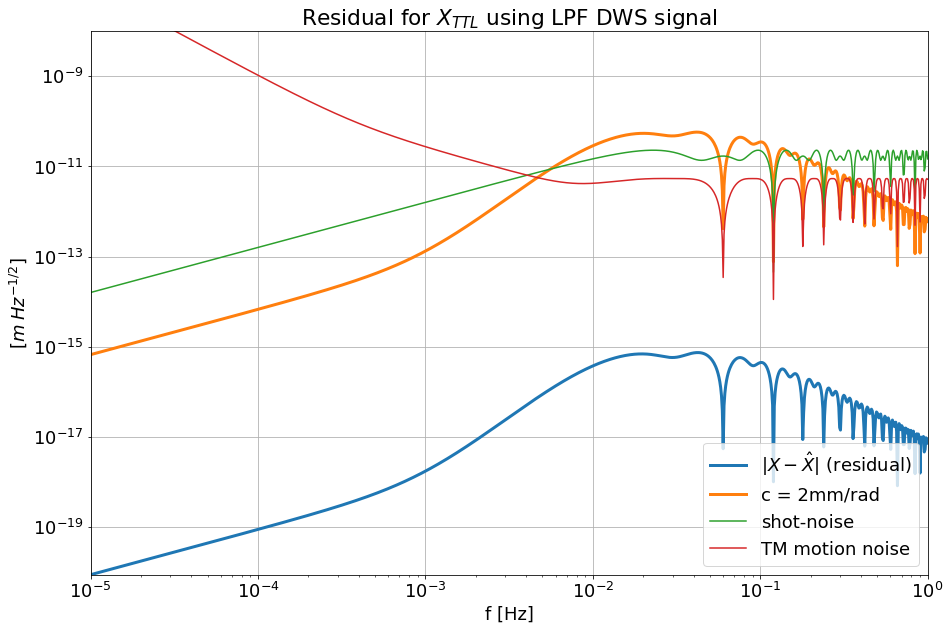

In [138]:
fig = plt.figure(figsize=(15, 10))
plt.title('Residual for $X_{TTL}$ using LPF DWS signal')
plt.loglog(freq, S_X_res**0.5, label='$|X-\hat{X}|$ (residual)', linewidth=3.0)
plt.loglog(freq, S_X**0.5, label='c = 2mm/rad', linewidth=3.0)
plt.loglog(freq, S_n_shot_x**0.5, label='shot-noise')
plt.loglog(freq, S_n_delta_x**0.5, label='TM motion noise')
plt.ylabel('$[m \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
plt.ylim([min(S_X_res**0.5), 1e-8])
plt.legend()
#plt.grid(True, which="both", ls="--")
plt.grid()
plt.savefig('Figures/X_residual_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

a = S_X_res**0.5
b = S_X**0.5
print(b[0]/a[0], (2e-3)/(0.25*s11))

In [139]:
## Getting residual (|X - Xhat|)

# DWS signals
phi1_psd  = ((10e-9)**2)*(1 + ((0.8e-3)/freq)**4)
phi1p_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
phi2p_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
phi3_psd  = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)

# Residual for X (from PSD of residual)
S_X2  = phi1_psd*(c11**2 + c22**2 + 2*c11*c22*cos(2*w*tau))
S_X2 += phi1p_psd*(c33**2 + c44**2 + 2*c33*c44*cos(2*w*tau))
S_X2 += phi2p_psd*(c55**2) + phi3_psd*(c66**2)
S_X2 *= (2 - 2*cos(2*w*tau))

S_X_res2  = phi1_psd*(s11**2 + s22**2 + 2*s11*s22*cos(2*w*tau))
S_X_res2 += phi1p_psd*(s33**2 + s44**2 + 2*s33*s44*cos(2*w*tau))
S_X_res2 += phi2p_psd*(s55**2) + phi3_psd*(s66**2)
S_X_res2 *= (2 - 2*cos(2*w*tau))

75701.0754212717 6.721572796400684e-09


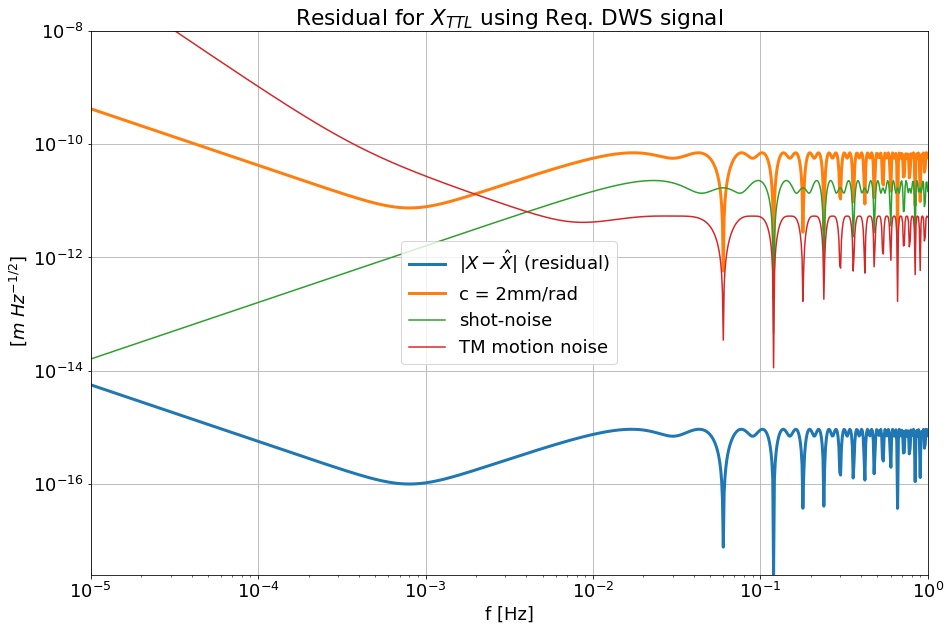

In [140]:
fig = plt.figure(figsize=(15, 10))
plt.title('Residual for $X_{TTL}$ using Req. DWS signal')
plt.loglog(freq, S_X_res2**0.5, label='$|X-\hat{X}|$ (residual)', linewidth=3.0)
plt.loglog(freq, S_X2**0.5, label='c = 2mm/rad', linewidth=3.0)
plt.loglog(freq, S_n_shot_x**0.5, label='shot-noise')
plt.loglog(freq, S_n_delta_x**0.5, label='TM motion noise')
plt.ylabel(' $[m \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
plt.ylim([min(S_X_res2**0.5), 1e-8])
plt.legend()
#plt.grid(True, which="both", ls="--")
plt.grid()
plt.savefig('Figures/X_residual_req-DWS.png', bbox_inches = 'tight', pad_inches = 0)

c = S_X_res2**0.5
d = S_X2**0.5
print(d[0]/c[0], 0.25*s11)


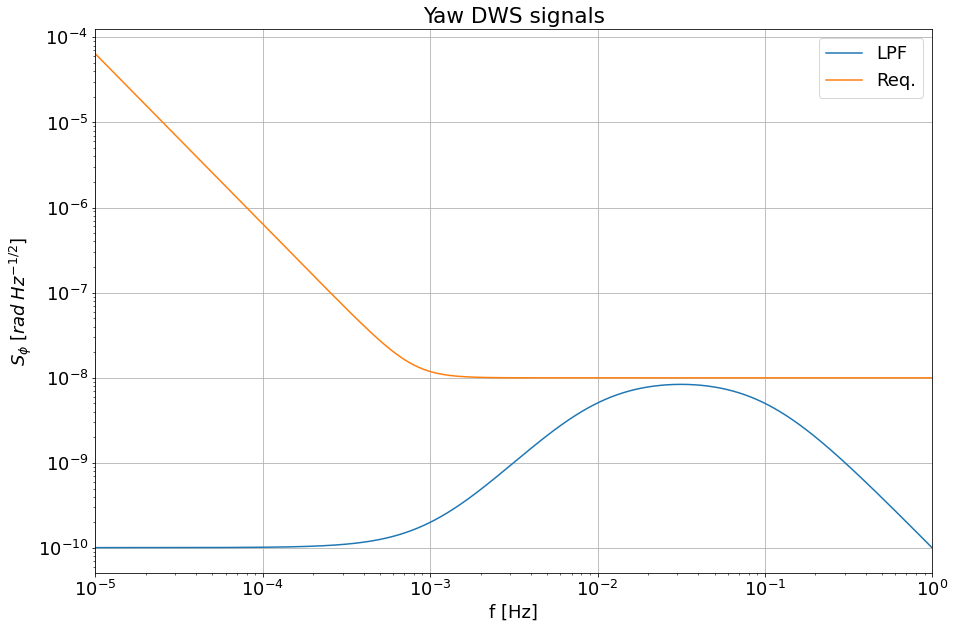

In [141]:
freq = w/(2*np.pi)
S_phi_LPF = ((40e-10)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
S_phi_req = ((10e-9)**2)*(1 + ((0.8e-3)/freq)**4)

fig = plt.figure(figsize=(15, 10))
plt.title('Yaw DWS signals')
plt.loglog(freq, S_phi_LPF**0.5, label='LPF')
plt.loglog(freq, S_phi_req**0.5, label='Req.')
plt.ylabel('$S_{\phi} \;[rad \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
plt.legend()
#plt.grid(True, which="both", ls="--")
plt.grid()
plt.savefig('Figures/phi_psd.png', bbox_inches = 'tight', pad_inches = 0)